In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time

In [3]:
coke = pd.read_excel("CocaCola_Sales_Rawdata.xlsx") 
coke

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [4]:
coke.isna().sum()

Quarter    0
Sales      0
dtype: int64

In [5]:
coke.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [6]:
coke.rename(columns={"Sales ('000)":"Sales"},inplace=True)

### Time Series 

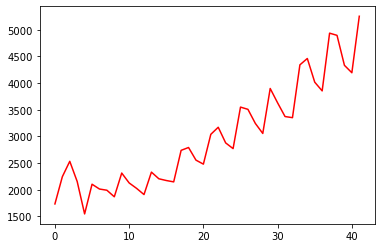

In [7]:
coke.Sales.plot(color='red'); # time series plot 

# Data Driven Model

### Moving Average

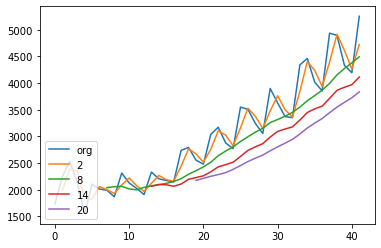

In [94]:
# moving average for the time series to understand better about the trend character 

coke.Sales.plot(label="org")
for i in range(2,24,6):
    coke["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

### Time Series Decomposition 

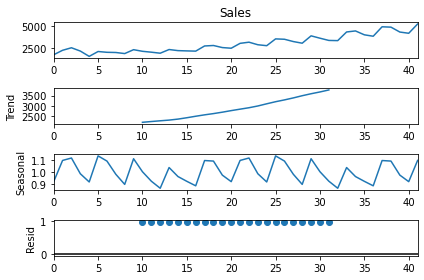

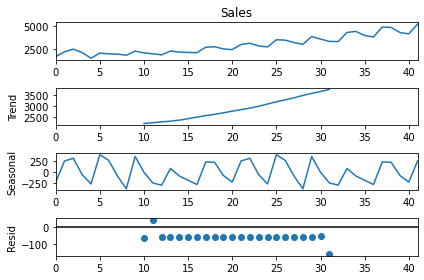

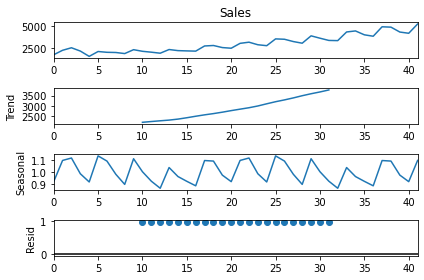

In [30]:
# Time series decomposition plot 

decompose_ts_add = seasonal_decompose(coke.Sales,model="additive",period=20)
decompose_ts_add.plot()
decompose_ts_mul = seasonal_decompose(coke.Sales,model="multiplicative",period=20)
decompose_ts_mul.plot()

### ACF Plots and PACF Plots 

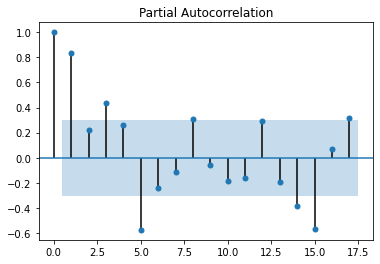

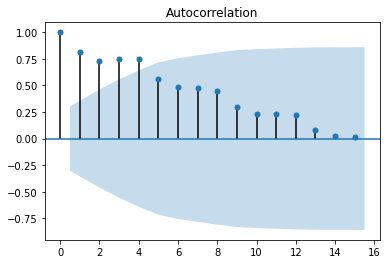

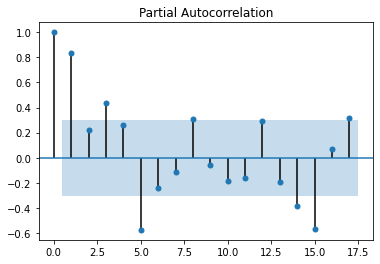

In [32]:
# ACF plots and PACF plots on Original data sets 
tsa_plots.plot_acf(coke.Sales,lags=15)
tsa_plots.plot_pacf(coke.Sales)

In [33]:
# Splitting data
Train = coke.head(30)
Test = coke.tail(12)

In [34]:
# Creating a function to calculate the MAPE value for test data 
def MAPE(pred,org):
    temp = np.abs((pred-org))*100/org
    return np.mean(temp)


#### Exponential Method

In [36]:
# Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Sales"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales) 

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


16.642022260813373

#### Holt Method

In [37]:
# Holt method 
hw_model = Holt(Train["Sales"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales) 

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


8.997964688624675

####  Holts winter exponential smoothing with additive seasonality and additive trend

In [38]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales)

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


5.673780088801724

####  Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [39]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales)

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


7.605669028457665

## Data Driven Final Model 

In [40]:
hwe_model_add_add = ExponentialSmoothing(coke["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [53]:
hwe_model_add_add.forecast(42)

42    4944.448416
43    4760.813899
44    4794.873684
45    5679.596290
46    5708.223445
47    5275.591980
48    5156.161011
49    6126.057248
50    5998.837231
51    5520.533496
52    5453.821837
53    6368.080079
54    6155.221575
55    5971.587059
56    6005.646844
57    6890.369450
58    6918.996605
59    6486.365139
60    6366.934171
61    7336.830407
62    7209.610391
63    6731.306656
64    6664.594997
65    7578.853239
66    7365.994735
67    7182.360219
68    7216.420003
69    8101.142609
70    8129.769764
71    7697.138299
72    7577.707331
73    8547.603567
74    8420.383550
75    7942.079815
76    7875.368156
77    8789.626398
78    8576.767895
79    8393.133378
80    8427.193163
81    9311.915769
82    9340.542924
83    8907.911459
dtype: float64

# Model Based Approach

In [55]:
coke = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
Quarter_dummies = pd.DataFrame(pd.get_dummies(coke['Quarter']))
coke1 = pd.concat([coke,Quarter_dummies],axis = 1)
coke1["t"] = np.arange(1,43)

coke1["t_squared"] = coke1["t"]*coke1["t"]
coke1.columns
coke1["log_Rider"] = np.log(coke1["Sales"])
coke1.rename(columns={"Sakes": 'Sales'}, inplace=True)

   Quarter        Sales  Q1_86  Q1_87  Q1_88  Q1_89  Q1_90  Q1_91  Q1_92  \
0    Q1_86  1734.827000      1      0      0      0      0      0      0   
1    Q2_86  2244.960999      0      0      0      0      0      0      0   
2    Q3_86  2533.804993      0      0      0      0      0      0      0   
3    Q4_86  2154.962997      0      0      0      0      0      0      0   
4    Q1_87  1547.818996      0      1      0      0      0      0      0   
5    Q2_87  2104.411995      0      0      0      0      0      0      0   
6    Q3_87  2014.362999      0      0      0      0      0      0      0   
7    Q4_87  1991.746998      0      0      0      0      0      0      0   
8    Q1_88  1869.049999      0      0      1      0      0      0      0   
9    Q2_88  2313.631996      0      0      0      0      0      0      0   
10   Q3_88  2128.320000      0      0      0      0      0      0      0   
11   Q4_88  2026.828999      0      0      0      0      0      0      0   
12   Q1_89  

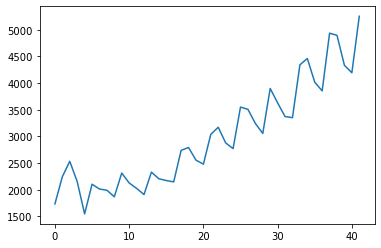

In [57]:
Train = coke1.head(80)
Test = coke1.tail(16)
print(coke1)
coke1.Sales.plot()

In [60]:
Train1 = coke.head(30)
Test1 = coke.tail(12)
coke1

,Quarter,Sales,Q1_86,Q1_87,Q1_88,Q1_89,Q1_90,Q1_91,Q1_92,Q1_93,...,Q4_89,Q4_90,Q4_91,Q4_92,Q4_93,Q4_94,Q4_95,t,t_squared,log_Rider
0,Q1_86,1734.827000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4,7.716443
2,Q3_86,2533.804993,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,9,7.837477
3,Q4_86,2154.962997,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,16,7.675529
4,Q1_87,1547.818996,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,25,7.344602
5,Q2_87,2104.411995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,36,7.651791
6,Q3_87,2014.362999,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,49,7.608058
7,Q4_87,1991.746998,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,64,7.596767
8,Q1_88,1869.049999,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,9,81,7.533186
9,Q2_88,2313.631996,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10,100,7.746574


### Heat Map 

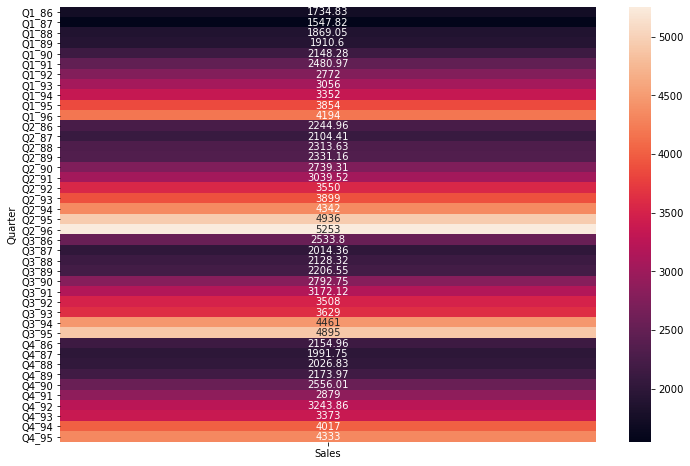

In [70]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=coke1,values="Sales",index="Quarter",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

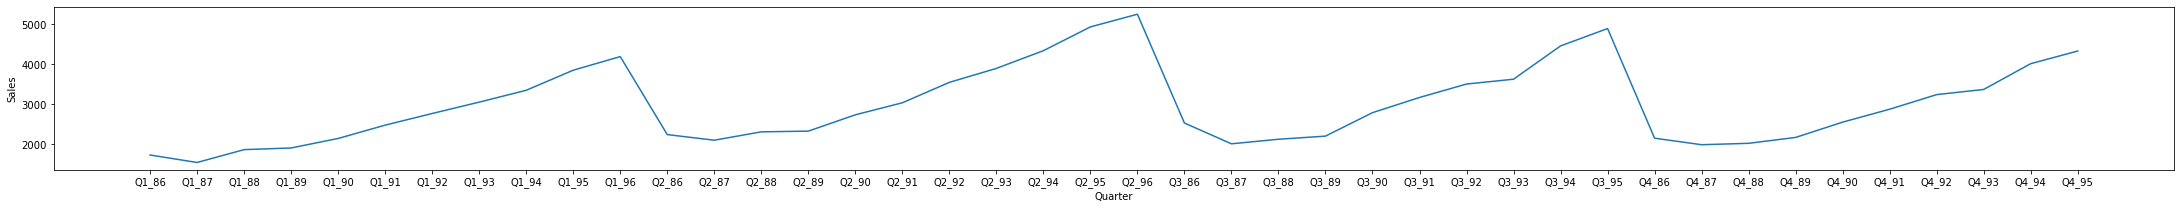

In [78]:
plt.figure(figsize=(38,3))
sns.lineplot(x="Quarter",y="Sales",data=coke1)

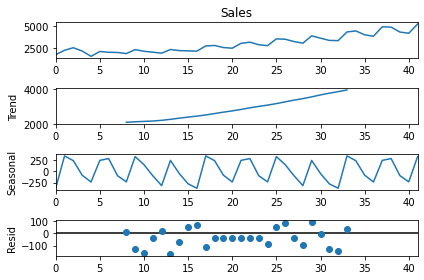

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(coke1.Sales,period=16)
decompose_ts_add.plot()
plt.show() 

#### Linear Model

In [80]:
import statsmodels.formula.api as smf 
linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2)) 
rmse_linear

419.0016017604827

####  Exponential

In [81]:
Exp = smf.ols('log_Rider~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp 

391.6269590081997

#### Quadratic 

In [82]:
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad 

374.8515530722881

In [87]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values']) 

,MODEL,RMSE_Values
2,rmse_Quad,374.851553
1,rmse_Exp,391.626959
0,rmse_linear,419.001602


In [88]:
predict_data = pd.read_csv("Predict_new (2).csv")   

In [89]:
predict_data  

,Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,t,t_squared
0,04-Apr,0,0,0,1,0,0,0,0,0,0,0,0,160,25600
1,04-May,0,0,0,0,1,0,0,0,0,0,0,0,161,25921
2,04-Jun,0,0,0,0,0,1,0,0,0,0,0,0,162,26244
3,04-Jul,0,0,0,0,0,0,1,0,0,0,0,0,163,26569
4,04-Aug,0,0,0,0,0,0,0,1,0,0,0,0,164,26896
5,04-Sep,0,0,0,0,0,0,0,0,1,0,0,0,165,27225
6,04-Oct,0,0,0,0,0,0,0,0,0,1,0,0,166,27556
7,04-Nov,0,0,0,0,0,0,0,0,0,0,1,0,167,27889
8,04-Dec,0,0,0,0,0,0,0,0,0,0,0,1,168,28224
9,05-Jan,1,0,0,0,0,0,0,0,0,0,0,0,169,28561


In [91]:
model_full = smf.ols('Sales~t+t_squared',data=coke1).fit()   

In [92]:
pred_new  = pd.Series(Quad.predict(predict_data)) 
pred_new

0     46079.254830
1     46633.542383
2     47191.290435
3     47752.498986
4     48317.168037
5     48885.297588
6     49456.887638
7     50031.938187
8     50610.449236
9     51192.420784
10    51777.852831
11    52366.745378
dtype: float64

In [93]:
predict_data["forecasted_Cocacola"] = pd.Series(pred_new) 
predict_data

,Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,t,t_squared,forecasted_Cocacola
0,04-Apr,0,0,0,1,0,0,0,0,0,0,0,0,160,25600,46079.254830
1,04-May,0,0,0,0,1,0,0,0,0,0,0,0,161,25921,46633.542383
2,04-Jun,0,0,0,0,0,1,0,0,0,0,0,0,162,26244,47191.290435
3,04-Jul,0,0,0,0,0,0,1,0,0,0,0,0,163,26569,47752.498986
4,04-Aug,0,0,0,0,0,0,0,1,0,0,0,0,164,26896,48317.168037
5,04-Sep,0,0,0,0,0,0,0,0,1,0,0,0,165,27225,48885.297588
6,04-Oct,0,0,0,0,0,0,0,0,0,1,0,0,166,27556,49456.887638
7,04-Nov,0,0,0,0,0,0,0,0,0,0,1,0,167,27889,50031.938187
8,04-Dec,0,0,0,0,0,0,0,0,0,0,0,1,168,28224,50610.449236
9,05-Jan,1,0,0,0,0,0,0,0,0,0,0,0,169,28561,51192.420784
